In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [2]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from sklearn.preprocessing import MinMaxScaler
import plotly.express as px
import plotly.figure_factory as ff

In [3]:
# Load preprocessed sensor data
with open("/content/drive/MyDrive/SmartFactory/Dataset/processed_sensor_data.json", 'r') as f:
    data = json.load(f)

In [4]:
df = pd.DataFrame(data)
df["timestamp"] = pd.to_datetime(df["timestamp"])
df.sort_values(by=["machine_id", "timestamp"], inplace=True)

In [5]:
df.head()

,timestamp,machine_id,temperature,vibration,rpm,pressure,humidity,voltage,failure,year,...,voltage_lag_1,voltage_lag_2,temperature_roc,vibration_roc,rpm_roc,pressure_roc,humidity_roc,voltage_roc,temperature_cummax,vibration_cummax
95,2015-07-31 12:04:03.644,A-M1A,77.28,0.88,2738,4.10,60.45,224.91,0,2015,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,77.28,0.88
163,2015-09-07 13:28:03.644,A-M1A,81.65,2.75,2507,7.80,64.32,215.76,0,2015,...,224.91,NaN,0.056548,2.125000,-0.084368,0.902439,0.064020,-0.040683,81.65,2.75
180,2015-09-19 00:26:23.644,A-M1A,97.90,2.99,2703,6.16,58.54,219.59,1,2015,...,215.76,224.91,0.199020,0.087273,0.078181,-0.210256,-0.089863,0.017751,97.90,2.99
242,2015-11-11 16:10:39.644,A-M1A,71.51,2.48,2848,5.85,60.60,221.02,0,2015,...,219.59,215.76,-0.269561,-0.170569,0.053644,-0.050325,0.035190,0.006512,97.90,2.99
253,2015-11-16 17:18:55.644,A-M1A,79.76,0.97,2795,7.42,43.60,232.19,0,2015,...,221.02,219.59,0.115368,-0.608871,-0.018610,0.268376,-0.280528,0.050538,97.90,2.99


In [6]:
# Simulate Failure Probability Score
np.random.seed(42)
df["failure_probability"] = np.where(df["failure"] == 1,
                                     np.random.uniform(0.85, 1.0, size=len(df)),
                                     np.random.uniform(0.0, 0.6, size=len(df)))

In [7]:
# Normalize metrics to create an "urgency score"
scaler = MinMaxScaler()
df[["temperature", "vibration", "rpm", "pressure", "humidity", "voltage"]] = scaler.fit_transform(
    df[["temperature", "vibration", "rpm", "pressure", "humidity", "voltage"]])
df["urgency_score"] = (df["failure_probability"] + df["vibration"] + df["temperature"]) / 3

In [8]:
# Generate Simulated Job Queue
machines = df["machine_id"].unique()
job_queue = []

for machine in machines:
    timestamps = df[df["machine_id"] == machine]["timestamp"].tolist()
    for i in range(0, len(timestamps), 20):
        job_queue.append({
            "job_id": f"JOB-{machine}-{i}",
            "machine_id": machine,
            "scheduled_time": timestamps[i],
            "estimated_duration_min": np.random.randint(20, 90),
            "priority_level": np.random.choice(["Low", "Medium", "High"], p=[0.2, 0.5, 0.3])
        })

job_df = pd.DataFrame(job_queue)

In [9]:
job_df.head()

,job_id,machine_id,scheduled_time,estimated_duration_min,priority_level
0,JOB-A-M1A-0,A-M1A,2015-07-31 12:04:03.644,74,High
1,JOB-A-M1A-20,A-M1A,2017-10-26 05:14:37.644,56,High
2,JOB-A-M1A-40,A-M1A,2020-03-21 22:20:02.644,46,Medium
3,JOB-A-M1A-60,A-M1A,2022-11-19 01:44:33.644,50,Medium
4,JOB-A-OUX-0,A-OUX,2015-06-06 01:07:51.644,63,Low


In [10]:
# Intelligent Rescheduling Logic
def intelligent_scheduler(job_df, df, fail_thresh=0.6, urgency_thresh=0.5):
    schedule_list = []

    for _, job in job_df.iterrows():
        state = df[(df["machine_id"] == job["machine_id"]) &
                   (df["timestamp"] <= job["scheduled_time"])]
        if state.empty:
            continue
        latest = state.iloc[-1]
        delay = timedelta(minutes=0)

        if latest["failure_probability"] > fail_thresh:
            delay = timedelta(minutes=60)
        elif latest["urgency_score"] > urgency_thresh:
            delay = timedelta(minutes=30)

        schedule_list.append({
            "job_id": job["job_id"],
            "machine_id": job["machine_id"],
            "original_time": job["scheduled_time"],
            "rescheduled_time": job["scheduled_time"] + delay,
            "duration": job["estimated_duration_min"],
            "failure_prob": round(latest["failure_probability"], 3),
            "urgency_score": round(latest["urgency_score"], 3),
            "priority": job["priority_level"],
            "delayed": delay.total_seconds() > 0
        })

    return pd.DataFrame(schedule_list)

scheduled_jobs = intelligent_scheduler(job_df, df)

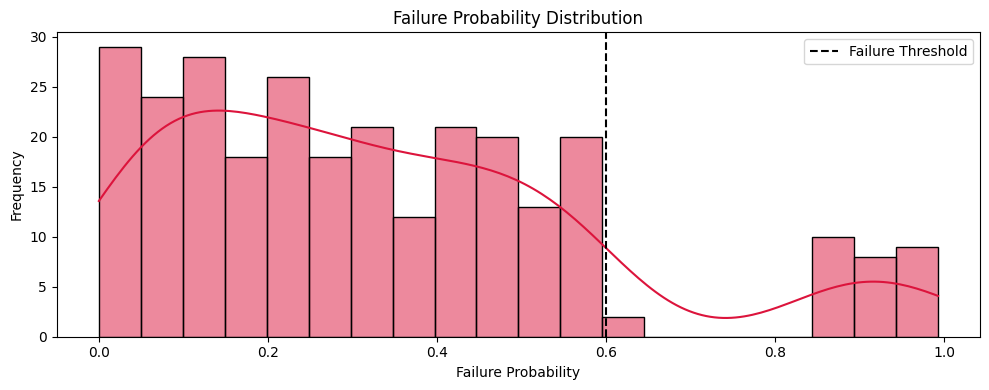

In [11]:
# Visualization – Job Delay Distribution
plt.figure(figsize=(10, 4))
sns.histplot(scheduled_jobs["failure_prob"], kde=True, bins=20, color='crimson')
plt.axvline(0.6, color='black', linestyle='--', label='Failure Threshold')
plt.title("Failure Probability Distribution")
plt.xlabel("Failure Probability")
plt.ylabel("Frequency")
plt.legend()
plt.tight_layout()
plt.show()

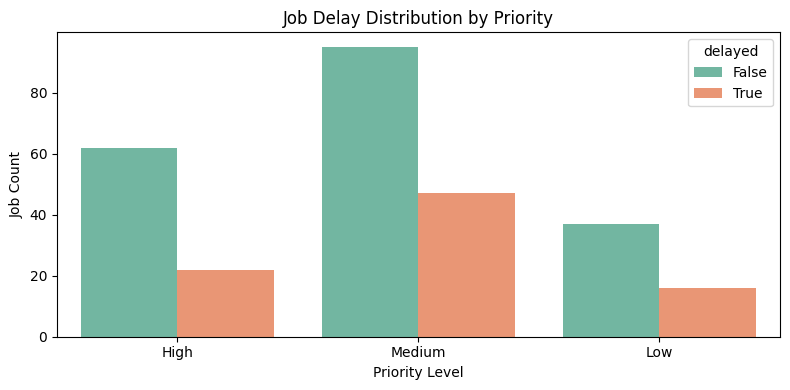

In [12]:
# Visualization – Rescheduling Status
plt.figure(figsize=(8, 4))
sns.countplot(data=scheduled_jobs, x="priority", hue="delayed", palette="Set2")
plt.title("Job Delay Distribution by Priority")
plt.ylabel("Job Count")
plt.xlabel("Priority Level")
plt.tight_layout()
plt.show()

In [13]:
# Interactive Gantt Chart for Visual Scheduling
def create_gantt(scheduled_jobs):
    df_gantt = scheduled_jobs.copy()
    df_gantt["Start"] = df_gantt["rescheduled_time"]
    df_gantt["Finish"] = df_gantt["Start"] + pd.to_timedelta(df_gantt["duration"], unit='min')
    df_gantt["Task"] = df_gantt["job_id"]
    df_gantt["Resource"] = df_gantt["priority"]
    fig = ff.create_gantt(df_gantt[["Task", "Start", "Finish", "Resource"]],
                          index_col="Resource", show_colorbar=True,
                          group_tasks=True, title="Factory Job Schedule")
    fig.show()

create_gantt(scheduled_jobs)

In [14]:
# Save Output
scheduled_jobs.to_json("/content/drive/MyDrive/SmartFactory/Results/Week7/optimized_schedule.json", orient='records', indent=2)